# Data Exploration

In [83]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import json
from datetime import datetime
import random

from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
import xgboost as xgb
from catboost import CatBoostRegressor

from scipy.special import boxcox1p, inv_boxcox1p
from scipy import stats
from scipy.stats import norm, skew

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures

from pycaret.regression import * 


import lightgbm as lgb
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge

import optuna 
import joblib
from optuna import Trial, visualization
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 100)

sns.set_style("white")
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.rcParams['figure.figsize'] = [16.0, 10.0]

def mean_absolute_percentage_error(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [489]:
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]
seed=111
p = 0.05
bc_dataframe = []
for date in dates:
    df = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    bc_dataframe.append(df)
bc_dataframe = pd.concat(bc_dataframe, axis=0)

# Preprocessing class

In [180]:
class DataFramePreProcessor:
    
    def __init__(self, dataframe, filter_threshold=50000, test=False):
        self.test = test
        self.original_dataframe = dataframe.copy()
        self.modeling_dataframe = None
        self.filter_threshold = filter_threshold
    
    
    def handleMissingData(self, dataframe):
        dataframe['ingreso_final'] = dataframe['ingreso_final'].fillna(0)
        dataframe['ind'] = dataframe['ind'].fillna(0)
        dataframe['tipo_vivienda'] = dataframe['tipo_vivienda'].fillna("NO INFORMA")
        dataframe['categoria'] = dataframe['categoria'].fillna("6")
        dataframe['estado_civil'] =dataframe['estado_civil'].fillna("NI")
        #dataframe['departamento_residencia'] = dataframe['departamento_residencia'].fillna("SIN INFORMACION")
        #dataframe['ocupacion'] = dataframe['ocupacion'].fillna("Otro")
        dataframe['ind_mora_vigente']  = dataframe['ind_mora_vigente'].fillna("N") 
        return dataframe
    
    
    def columnFilter(self, dataframe):
        to_drop = [
            "Unnamed: 0",
            "id_cli",
            "pol_centr_ext",
            "ult_actual",
            "cant_mora_30_tdc_ult_3m_sf",
            "cant_mora_30_consum_ult_3m_sf",
            "ind",
            "cat_ingreso",
            "departamento_residencia",
            "ocupacion",
            "estado_civil",
            "tipo_vivienda",
            #"nivel_academico",
            "rep_calif_cred",
            "tiene_ctas_activas",
            "mora_max"
            
        ]
        
            
        dataframe = dataframe.drop(to_drop,axis=1, errors='ignore')
        return dataframe
    
    
    # Borrar filas deacuerdo a cierta logica de negocio
    def rowFilter(self, dataframe):
        cut = 0.9999
        return dataframe[
            #(dataframe['edad'] < 100) & # Imputar a percentil 99
            (dataframe['gasto_familiar'] >= 50000) &
            #(dataframe['edad'] >=20) &
            (dataframe['gasto_familiar'] < 30000000) &
            # (dataframe['cant_oblig_tot_sf'] < 13) &
            (dataframe['cuota_de_consumo'] >= 0) & # Mas bien transformar a cero
            (dataframe['ingreso_final'] < 50000000) &
            (dataframe['cuota_cred_hipot'] >= 0) &
            (dataframe['tiene_ctas_activas'] == 0)
        ] 
        dataframe[
                #(dataframe['edad'] < 100) & # Imputar a percentil 99
                (dataframe['gasto_familiar'] > self.filter_threshold) &
                #(dataframe['edad'] >=20) &
                (dataframe['gasto_familiar'] < np.quantile(dataframe['gasto_familiar'], cut)) &
                # (dataframe['cant_oblig_tot_sf'] < 13) &
                #(dataframe['cuota_de_consumo'] >= 0) & # Mas bien transformar a cero
                (dataframe['ingreso_final'] < np.quantile(dataframe['ingreso_final'], cut)) &
                #(dataframe['cuota_cred_hipot'] >= 0) &
                (dataframe['cupo_total_tc'] < np.quantile(dataframe['cupo_total_tc'], cut)) & # Percentil 99%
                (dataframe['cuota_tc_bancolombia'] < np.quantile(dataframe['cuota_tc_bancolombia'], cut)) & # percentil 99.99%
                (dataframe['cuota_de_vivienda'] < np.quantile(dataframe['cuota_de_vivienda'], cut)) &# Percentil 99.99%
                (dataframe['cuota_de_consumo'] < np.quantile(dataframe['cuota_de_consumo'], cut)) & # percentil 99%
                (dataframe['cuota_rotativos'] < np.quantile(dataframe['cuota_rotativos'], cut))& # percentil 99.99%
                (dataframe['cuota_tarjeta_de_credito'] < np.quantile(dataframe['cuota_tarjeta_de_credito'], cut)) & 
                (dataframe['cuota_de_sector_solidario'] < np.quantile(dataframe['cuota_de_sector_solidario'], cut)) &
                (dataframe['cuota_sector_real_comercio'] < np.quantile(dataframe['cuota_sector_real_comercio'], cut)) &# Percentil 99.5%
                (dataframe['cuota_libranza_sf'] < np.quantile(dataframe['cuota_libranza_sf'], cut)) & # Percentil 99
                (dataframe['ingreso_segurida_social'] < np.quantile(dataframe['ingreso_segurida_social'], cut)) & # percentil 99.9
                (dataframe['ingreso_nomina'] < np.quantile(dataframe['ingreso_nomina'], cut)) &
                (dataframe['saldo_prom3_tdc_mdo'] < np.quantile(dataframe['saldo_prom3_tdc_mdo'], cut)) &
                (dataframe['saldo_no_rot_mdo'] < np.quantile(dataframe['saldo_no_rot_mdo'], cut)) &
                (dataframe['cuota_cred_hipot'] < np.quantile(dataframe['cuota_cred_hipot'], cut)) &
                (dataframe['mediana_nom3'] < np.quantile(dataframe['mediana_nom3'], cut)) &
                (dataframe['mediana_pen3'] < np.quantile(dataframe['mediana_pen3'], cut)) &
                (dataframe['cuota_tc_mdo'] < np.quantile(dataframe['cuota_tc_mdo'], cut)) &
                (dataframe['ingreso_nompen'] < np.quantile(dataframe['ingreso_nompen'], cut)) &
                (dataframe['cant_oblig_tot_sf'] <= 15) &
                (dataframe['ctas_activas'] < 5) &
                (dataframe['nro_tot_cuentas'] < 5) 
              #  ~(dataframe['departamento_residencia'].isin(['MADRID', 'ESTADO DE LA FLORIDA', 'VAUPES']))
            ] 
    
    def oneEncodeVariables(self):
        pass
    
    def processVars(self, dataframe):
        
        # Transformacion demograficas
        dataframe['genero'] = np.where(dataframe['genero'] == 'M', 0, 1)
        dataframe['edad'] = np.where(dataframe['edad'] < 18, 18,
                                    np.where(dataframe['edad'] > 80, 80, dataframe['edad']
                                    ))
        dataframe['educacion_grupo'] = np.where(
            dataframe['nivel_academico'].isin(['PRIMARIO', 'UNIVERSITARIO', 'ESPECIALIZACION']),1,0
        )

       # dataframe['tipo_vivienda'] =  np.where(dataframe['tipo_vivienda'].isin(["\\N", "NO INFORMA"]),"OTRO", dataframe['tipo_vivienda'])
        dataframe['categoria']=np.where(dataframe['categoria']=='\\N', "6",dataframe['categoria'])
        dataframe['categoria']=dataframe['categoria'].astype(float).astype(int)
        #dataframe['ocupacion']=np.where(dataframe['ocupacion'].isin(
        #        ["\\N", "Agricultor", "Ganadero", 'Vacío', "Ama de casa", "Sin Ocupacion Asignada"]), "Otro",
        #                               np.where(dataframe['ocupacion'] == "Pensionado", "Jubilado", dataframe['ocupacion']
        #                                       ))
        
        #dataframe['departamento_residencia'] = \
        #    np.where(
        #        dataframe['departamento_residencia'].isin(['\\N', 'NARIÑO', 'NARI#O', 'VAUPES','MADRID', 'ESTADO DE LA FLORIDA']),
        #        "SIN INFORMACION", dataframe['departamento_residencia'] )
        
        #dataframe['es_ciudad_principal'] = np.where(
        #    dataframe['departamento_residencia'].isin(['BOGOTA D.C.', 'ANTIOQUIA', 'VALLE', 'CUNDINAMARCA']), 1,0)  
        #dataframe['estado_civil'] = np.where(dataframe['estado_civil'] == "NI", "OTRO", dataframe['estado_civil'])
        
        dataframe['ind_mora_vigente'] = np.where(dataframe['ind_mora_vigente'] == "S", 1, 0)
        dataframe['convenio_lib'] = np.where(dataframe['convenio_lib'] == 'S', 1, 0)
        # Transformacion finacieras
        dataframe['ingreso_calculado'] =  dataframe['ingreso_segurida_social']  +  \
                                          dataframe[['ingreso_nompen', 'ingreso_nomina']].max(axis=1)
        dataframe['ingreso_corr'] = dataframe[['ingreso_final', 'ingreso_calculado']].max(axis=1)
        
        dataframe['cuota_cred_hipot'] = dataframe[['cuota_cred_hipot', 'cuota_de_vivienda']].max(axis=1)
        
        dataframe['cuota_de_consumo'] =np.where(dataframe['cuota_de_consumo'] < 0, 0, dataframe['cuota_de_consumo'])
        dataframe['cuota_cred_hipot'] =np.where(dataframe['cuota_cred_hipot'] < 0, 0, dataframe['cuota_cred_hipot'])                                        
                
        pct_vars = [
            'cuota_cred_hipot',
            'cuota_tarjeta_de_credito',
            'cuota_de_consumo',
            'cuota_rotativos',
            'cuota_sector_real_comercio',
            'cuota_de_sector_solidario',
            'cuota_tc_bancolombia',
            'cuota_libranza_sf',
            'cupo_total_tc',
            'cupo_tc_mdo'
        ]
        
        for var in pct_vars:
            dataframe[f"{var}_pct"] = dataframe[var] / dataframe['ingreso_corr']  * 100
            dataframe[f"{var}_pct"] = dataframe[f"{var}_pct"].replace(dict.fromkeys([np.nan, np.inf], 0))
    
        dataframe['obl_total_pct'] = dataframe['cuota_cred_hipot_pct'] + \
                                     dataframe['cuota_tarjeta_de_credito_pct'] +\
                                     dataframe['cuota_de_consumo_pct'] + \
                                     dataframe['cuota_rotativos_pct'] + \
                                     dataframe['cuota_sector_real_comercio_pct'] + \
                                     dataframe['cuota_de_sector_solidario_pct'] + \
                                     dataframe['cuota_sector_real_comercio_pct'] 
        
                                    
        dataframe['total_cuota'] = dataframe['cuota_cred_hipot'] + \
                                   dataframe['cuota_tarjeta_de_credito'] + \
                                   dataframe['cuota_de_consumo'] + \
                                   dataframe['cuota_rotativos'] + \
                                   dataframe['cuota_de_sector_solidario'] + \
                                   dataframe['cuota_libranza_sf'] + \
                                   dataframe['cuota_tarjeta_de_credito'] + \
                                   dataframe['cuota_tc_bancolombia']
        
        dataframe['total_cupo'] = dataframe['cupo_total_tc'] + dataframe['cupo_tc_mdo']
        dataframe['ingreso_cero'] = np.where(dataframe['ingreso_corr'] == 0, 1, 0)
        
        # Variables de interaccion
        dataframe['interact_ing_gen']  = dataframe['genero'] * dataframe['ingreso_corr']
        dataframe['interact_ing_ed']  = dataframe['edad'] * dataframe['ingreso_corr']
        dataframe['interact_cup_gen']  = dataframe['genero'] * dataframe['total_cupo']
        dataframe['interact_cup_ed']  = dataframe['edad'] * dataframe['total_cupo']
        #dataframe['interact_obl_gen'] = dataframe['genero'] * dataframe['obl_total_pct']
        #dataframe['interact_obl_ed']  = dataframe['edad'] * dataframe['obl_total_pct']    

        #dataframe['ingreso_geo_alto']  = np.where(dataframe['ingreso_corr'] < 14.90, 1, 0) # ALgo mas tecnico

    
        #dataframe['pc25'] = np.where(dataframe['ingreso_corr'] <= np.quantile(dataframe['ingreso_corr'],0.25), 1, 0)
        #dataframe['pc75'] = np.where(dataframe['ingreso_corr'] >= np.quantile(dataframe['ingreso_corr'],0.75), 1, 0)

        # variables al cuadrado
        
        #dataframe['edad_2'] = dataframe['edad']**2
        dataframe['total_cuota_2']  =dataframe['total_cuota']**2
        #dataframe['total_cupo_2']  =dataframe['total_cupo']**2
        #dataframe['obl_total_pct_2'] = dataframe['obl_total_pct']**2
        #dataframe['ingreso_corr2'] = dataframe['ingreso_corr']**2 
        
        
        #dataframe['cupo_pct'] = dataframe['total_cupo']/dataframe['ingreso_corr']
        dataframe['cupo_disponible'] = dataframe['total_cupo'] - dataframe['cuota_tarjeta_de_credito'] - \
                                       dataframe['cuota_tc_bancolombia']
        #dataframe['liquidez'] = dataframe['cupo_disponible'] + dataframe['ingreso_corr']
        #dataframe['liquidez_c'] = dataframe['total_cupo'] + dataframe['ingreso_corr']
        dataframe['cuota_pct_cupo'] = (dataframe['cuota_tarjeta_de_credito'] + dataframe['cuota_tc_bancolombia']) / dataframe['total_cupo']
        #dataframe['ind_corregido'] = dataframe['ingreso_corr'] - dataframe['total_cuota'] - dataframe['ingreso_corr']*0.1
        #dataframe['ratio_cupo'] = dataframe['cupo_tc_mdo']/dataframe['cupo_tc_mdo']
        
        dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)

        
        if not self.test:
            dataframe['log_gasto_familiar'] = np.log1p(dataframe['gasto_familiar']) 
            numeric_feats = dataframe.drop(['gasto_familiar',
                                            'log_gasto_familiar'], axis=1).dtypes[
                    (dataframe.dtypes == "float64")].index
        else:
            numeric_feats = dataframe.dtypes[
                    (dataframe.dtypes == "float64")].index
            
        skewed_feats = dataframe[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
        skewness = pd.DataFrame({'Skew' :skewed_feats})
        skewness = skewness[abs(skewness) > 0.75]       
        skewed_features = skewness.index
        lam = 0.5
        PT_transformer = PowerTransformer()
        for feat in skewed_features:
             dataframe[feat] = boxcox1p(dataframe[feat], lam)        
            #dataframe[feat] = PT_transformer.fit_transform(dataframe[feat].values.reshape(-1,1))
            
            
        cat_vars = [
            #'mora_max',
            #'estado_civil',
            #'rep_calif_cred',
            #'ocupacion',
            #'tipo_vivienda',
            #'nivel_academico',
            #'departamento_residencia'
        ]
        if cat_vars:
            dummified = []
            for var in cat_vars:            
                dummified.append(
                    pd.get_dummies(dataframe[var], drop_first=True, prefix=var)
                )

            dummified = pd.concat(dummified, axis=1)
            dataframe = pd.concat([dataframe.drop(cat_vars, axis=1),dummified], axis=1)

        ## Final cleaning
        
        dataframe.drop(["ingreso_final", "ingreso_calculado",
                        "cuota_de_vivienda", "gasto_familiar",
                        #"cupo_total_tc",
                        "cupo_total_tc_pct", "cupo_tc_mdo_pct", "cupo_disponible",
                        #"cupo_tc_mdo",
                        #"cupo_total_tc",
                        "ingreso_nompen", "ingreso_nomina", "ingreso_segurida_social",
                        "ingreso_cero",
                        "tenencia_tc", # Alta correlacion con cuota tarjeta de credito
                        "ctas_activas", # Alta correlacion con nto_tot_cuentas
                        "cuota_cred_hipot_pct", #altta correlacion con cuota credito hipotecario
                        "cuota_de_consumo_pct", #Alta correlacion con cuta de consumo
                        "cuota_rotaticos_pct", # Alta correlacion con cuota de rotativos
                        "cuota_tarjeta_de_credito_pct",
                        "cuota_de_sector_solidario_pct",
                        "cuota_sector_real_comercio_pct",
                        "cuota_libranza_sf_pct",
                        "cuota_tc_bancolombia_pct",
                        "cuota_rotativos_pct",
                        # REVISAR BIEN
                        "saldo_no_rot_mdo",
                        "total_cuota",
                        "total_cupo",
                        "convenio_lib",
                        "ind_mora_vigente",
                        #'cuota_cred_hipot',
                        #'cuota_tarjeta_de_credito',
                        #'cuota_de_consumo',
                        #'cuota_rotativos',
                        #'cuota_sector_real_comercio',
                        #'cuota_de_sector_solidario',
                        #'cuota_tc_bancolombia',
                        #'cuota_libranza_sf',
                        "tiene_consumo",
                        #"cuota_tc_mdo",
                        "tiene_crediagil",
                        "nivel_academico",
                        "total_cupo",
                        "genero",
                        "nro_tot_cuentas",
                        "mediana_nom3",
                        "mediana_pen3",
                        "cant_oblig_tot_sf",
                        "saldo_prom3_tdc_mdo",
                        "categoria",
                        "cuota_pct_cupo"
                       ], axis=1, inplace=True,  errors='ignore')
        dataframe.fillna(0, inplace=True)

        return dataframe
    
    def process(self):
        
        complete_df = self.columnFilter(
                self.handleMissingData(self.original_dataframe)
        )
        if not self.test:
            filtered_df = self.rowFilter(complete_df)
            grown_df    = self.processVars(filtered_df)
        else:
            grown_df    = self.processVars(complete_df)
        self.modeling_dataframe = grown_df
        
        return self.modeling_dataframe
        

# Hyperparameter tuning class

In [490]:
class ModelTuning:
    
    
    def __init__(self, X, y, algorithm):
        self.X = X
        self.y = y
        self.algorithm = algorithm
        self.best_params= None
    
    def objective(self, trial: Trial, X, y, algorithm) -> float:
        
        if algorithm == 'xgb':
                params = {
                    "n_estimators" : trial.suggest_int('n_estimators', 50, 200),
                    'max_depth':trial.suggest_int('max_depth', 2, 20),
                    'reg_alpha':trial.suggest_int('reg_alpha', 0, 8),
                    'reg_lambda':trial.suggest_int('reg_lambda', 0, 8),
                    'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                    'gamma':trial.suggest_int('gamma', 0, 5),
                    'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.5),
                    'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                    'nthread' : -1
                }
                model_ = xgb.XGBRegressor(**params)
                
        elif algorithm == 'catboost':
            params = {
                "n_estimators" : trial.suggest_int('n_estimators', 0, 200),
                "learning_rate": trial.suggest_loguniform('learning_rate',0.01,0.5),
                "depth": trial.suggest_int('depth', 6, 10),
                "l2_leaf_reg": trial.suggest_int('l2_leaf_reg', 2, 30),
                "bagging_temperature": trial.suggest_discrete_uniform('bagging_temperature',0.1,1,0.01)
            }
            model_ = CatBoostRegressor(**params, verbose=False)
        elif algorithm == 'ridge':
            params = {
                 "alpha": trial.suggest_loguniform("alpha", 0.01, 100)
            }
            model_ =Ridge(**params)
        else:
            params = {
            "alpha": trial.suggest_loguniform("alpha", 0.01, 100),
            "l1_ratio": trial.suggest_loguniform("l1_ratio", 0.01, 1)
            }
            model_ = ElasticNet(**params)
            
        # joblib.dump(study, 'study.pkl')
    
        train_X,test_X,train_y,test_y = train_test_split(X, y, test_size = 0.30,random_state = 101)
        model_.fit(train_X,train_y)
        predictions = model_.predict(test_X)

        return mean_absolute_percentage_error(predictions,test_y)
    
    
    def getHyperParameters(self):
        
        study = optuna.create_study(direction='minimize',sampler=TPESampler())
        study.optimize(lambda trial : self.objective(trial, self.X, self.y, self.algorithm),n_trials= 20)
        study.best_trial.params
        print('Best trial {}: score {},\nparams {}'.format(self.algorithm,study.best_trial.value,study.best_trial.params))
        self.best_params=study.best_trial.params

In [492]:
fe_dataframe = DataFramePreProcessor(bc_dataframe)
fe_dataframe.process()
X = fe_dataframe.modeling_dataframe.drop(["log_gasto_familiar"], axis=1)
y = fe_dataframe.modeling_dataframe['log_gasto_familiar']
stack_models = ['xgb', 'catboost', 'elasticnet', 'ridge']
best_hyp= {}
for model_ in stack_models:
    tuning_model=ModelTuning(X, y, model_)
    tuning_model.getHyperParameters()
    best_hyp[model_] = tuning_model.best_params
    
with open(f'tuned_hyper_parameters.json', 'w') as fp:
    json.dump(best_hyp, fp, indent=4)

[I 2021-01-23 18:11:43,081] A new study created in memory with name: no-name-aa879c10-f7e3-41a1-8a59-ce8299aadbf9
[I 2021-01-23 18:13:01,095] Trial 0 finished with value: 0.1790086526379941 and parameters: {'n_estimators': 165, 'max_depth': 16, 'reg_alpha': 7, 'reg_lambda': 2, 'min_child_weight': 3, 'gamma': 3, 'learning_rate': 0.01121615219395135, 'colsample_bytree': 0.31}. Best is trial 0 with value: 0.1790086526379941.
[I 2021-01-23 18:13:49,914] Trial 1 finished with value: 0.7886495923257532 and parameters: {'n_estimators': 65, 'max_depth': 17, 'reg_alpha': 3, 'reg_lambda': 6, 'min_child_weight': 0, 'gamma': 2, 'learning_rate': 0.011929725555792631, 'colsample_bytree': 0.99}. Best is trial 0 with value: 0.1790086526379941.
[I 2021-01-23 18:16:56,312] Trial 2 finished with value: 0.06158330902250019 and parameters: {'n_estimators': 164, 'max_depth': 15, 'reg_alpha': 2, 'reg_lambda': 5, 'min_child_weight': 0, 'gamma': 5, 'learning_rate': 0.40528369846600276, 'colsample_bytree': 0.33

Best trial xgb: score 0.06060888691334632,
params {'n_estimators': 128, 'max_depth': 6, 'reg_alpha': 6, 'reg_lambda': 1, 'min_child_weight': 4, 'gamma': 4, 'learning_rate': 0.09068007494436822, 'colsample_bytree': 0.93}


[I 2021-01-23 18:42:46,623] Trial 0 finished with value: 0.060526418625771815 and parameters: {'n_estimators': 118, 'learning_rate': 0.2687897646714193, 'depth': 9, 'l2_leaf_reg': 25, 'bagging_temperature': 0.41000000000000003}. Best is trial 0 with value: 0.060526418625771815.
[I 2021-01-23 18:43:17,185] Trial 1 finished with value: 0.06142036515146759 and parameters: {'n_estimators': 199, 'learning_rate': 0.011421836664131099, 'depth': 8, 'l2_leaf_reg': 8, 'bagging_temperature': 0.72}. Best is trial 0 with value: 0.060526418625771815.
[I 2021-01-23 18:43:26,921] Trial 2 finished with value: 0.060713596809140014 and parameters: {'n_estimators': 46, 'learning_rate': 0.41323613591884206, 'depth': 6, 'l2_leaf_reg': 8, 'bagging_temperature': 0.22}. Best is trial 0 with value: 0.060526418625771815.
[I 2021-01-23 18:43:53,742] Trial 3 finished with value: 0.061356063200342745 and parameters: {'n_estimators': 150, 'learning_rate': 0.016662425134104777, 'depth': 8, 'l2_leaf_reg': 30, 'bagging

Best trial catboost: score 0.060516696948939235,
params {'n_estimators': 130, 'learning_rate': 0.22611074333908893, 'depth': 9, 'l2_leaf_reg': 24, 'bagging_temperature': 0.1}


[I 2021-01-23 18:51:38,113] Trial 0 finished with value: 0.06257590601134279 and parameters: {'alpha': 0.308093348055161, 'l1_ratio': 0.09637327658145922}. Best is trial 0 with value: 0.06257590601134279.
[I 2021-01-23 18:51:39,586] Trial 1 finished with value: 0.06398867189201259 and parameters: {'alpha': 10.514284464123424, 'l1_ratio': 0.08634477051998907}. Best is trial 0 with value: 0.06257590601134279.
[I 2021-01-23 18:51:44,403] Trial 2 finished with value: 0.0625120190773165 and parameters: {'alpha': 0.34331940763902097, 'l1_ratio': 0.011647724033862442}. Best is trial 2 with value: 0.0625120190773165.
[I 2021-01-23 18:51:46,898] Trial 3 finished with value: 0.06289042262592623 and parameters: {'alpha': 2.509298864218717, 'l1_ratio': 0.03367854163648413}. Best is trial 2 with value: 0.0625120190773165.
[I 2021-01-23 18:51:48,091] Trial 4 finished with value: 0.06679686827352997 and parameters: {'alpha': 17.46131680940701, 'l1_ratio': 0.37673815715213804}. Best is trial 2 with va

Best trial elasticnet: score 0.062434793697355426,
params {'alpha': 0.01043683315485499, 'l1_ratio': 0.01752370125180038}


[I 2021-01-23 18:53:02,369] Trial 0 finished with value: 0.06679686827352997 and parameters: {'alpha': 6.329068890140856}. Best is trial 0 with value: 0.06679686827352997.
[I 2021-01-23 18:53:03,387] Trial 1 finished with value: 0.06679686827352997 and parameters: {'alpha': 28.172298004577772}. Best is trial 0 with value: 0.06679686827352997.
[I 2021-01-23 18:53:06,196] Trial 2 finished with value: 0.0625084600401314 and parameters: {'alpha': 0.02297822106618983}. Best is trial 2 with value: 0.0625084600401314.
[I 2021-01-23 18:53:07,495] Trial 3 finished with value: 0.06352880795695132 and parameters: {'alpha': 0.6362679078327195}. Best is trial 2 with value: 0.0625084600401314.
[I 2021-01-23 18:53:08,741] Trial 4 finished with value: 0.06504004492802878 and parameters: {'alpha': 1.6865155105725784}. Best is trial 2 with value: 0.0625084600401314.
[I 2021-01-23 18:53:11,094] Trial 5 finished with value: 0.06257863557294437 and parameters: {'alpha': 0.049129128881061024}. Best is trial

Best trial lasso: score 0.06248617553780655,
params {'alpha': 0.010197390039305795}


[I 2021-01-23 18:53:44,268] Trial 0 finished with value: 0.062434252589166246 and parameters: {'alpha': 0.11941262732747229}. Best is trial 0 with value: 0.062434252589166246.
[I 2021-01-23 18:53:45,263] Trial 1 finished with value: 0.06243425012323892 and parameters: {'alpha': 9.742692051644443}. Best is trial 1 with value: 0.06243425012323892.
[I 2021-01-23 18:53:46,240] Trial 2 finished with value: 0.062434251470269354 and parameters: {'alpha': 4.466839545557503}. Best is trial 1 with value: 0.06243425012323892.
[I 2021-01-23 18:53:47,207] Trial 3 finished with value: 0.06243424852571148 and parameters: {'alpha': 16.041006243474424}. Best is trial 3 with value: 0.06243424852571148.
[I 2021-01-23 18:53:48,158] Trial 4 finished with value: 0.06243425261408062 and parameters: {'alpha': 0.022713122213012683}. Best is trial 3 with value: 0.06243424852571148.
[I 2021-01-23 18:53:49,115] Trial 5 finished with value: 0.06243425203491128 and parameters: {'alpha': 2.271849267965015}. Best is 

Best trial ridge: score 0.062434229396970235,
params {'alpha': 94.90403234662571}


## Loggin class

In [16]:
class ModelLogging:
    
    
    def __init__(self):
        pass
    
    def getMetadata(self):
        pass
    
    def writeJSON(self):
        pass

# Modeling

In [181]:
bc_dataframe = pd.read_csv("train_202003_cleaned.csv",skiprows=lambda i: i>0 and random.random() > 0.1)
bc_dataframe = bc_dataframe[bc_dataframe['gasto_familiar'] >0]
fe_dataframe = DataFramePreProcessor(bc_dataframe)
fe_dataframe.process()
# modeling = fe_dataframe.modeling_dataframe[fe_dataframe.modeling_dataframe['total_cuota'] < -1.5]
X = fe_dataframe.modeling_dataframe.drop(['log_gasto_familiar', 'periodo'], axis=1)
y = fe_dataframe.modeling_dataframe['log_gasto_familiar']

#scaled_data = scale(X) # promedio de los valores de cada gene debe ser cero con std 1
#pca = PCA()
#pca.fit(scaled_data )# Matemática del PCA
#pca_data = pca.transform(scaled_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

xgb_reg = xgb.XGBRegressor(objective='reg:squaredlogerror', n_estimators=50, random_state=101)
elastic_params ={'alpha': 0.010151733000510865, 'l1_ratio': 0.010077935175737287}
elastic_reg = ElasticNet(**elastic_params)
#lasso_reg=Lasso()
ridge_reg=Ridge()
cat_reg = CatBoostRegressor(n_estimators=10)
#rf_reg = RandomForestRegressor()
cat_reg.fit(X_train, y_train, verbose=False)
#model_lgb = lgb.LGBMRegressor(objective='regression')
#model_lgb.fit(X_train, y_train)
#lasso_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
elastic_reg.fit(X_train, y_train)
# rf_reg.fit(X_train, y_train)

KeyError: 'tiene_ctas_activas'

In [36]:
# BoxCox, Robust Scaler, Standard Scaler, Power Transformer
var= 'ind'
test_dataframe=bc_dataframe[(bc_dataframe[var] < np.quantile(bc_dataframe[var], 0.999)) |
                           (bc_dataframe[var] >= 0) ]

transformer = PowerTransformer()
sscaler = StandardScaler()
rscaler = RobustScaler()
rs_transformed = rscaler.fit_transform(test_dataframe[var].values.reshape(-1,1))
ss_transformed = sscaler.fit_transform(test_dataframe[var].values.reshape(-1,1))
boxcox_transformed= boxcox1p(test_dataframe[var], 0.05)
PT_transformed =  transformer.fit_transform(test_dataframe[var].values.reshape(-1,1))

In [24]:
test_dataframe['ind'].describe()

count       76712.00000
mean      2448435.17915
std       7228575.88222
min             0.00000
25%        472968.00000
50%       1102744.38000
75%       2405318.83709
max     512973180.76762
Name: ind, dtype: float64

<AxesSubplot:xlabel='ind', ylabel='Density'>

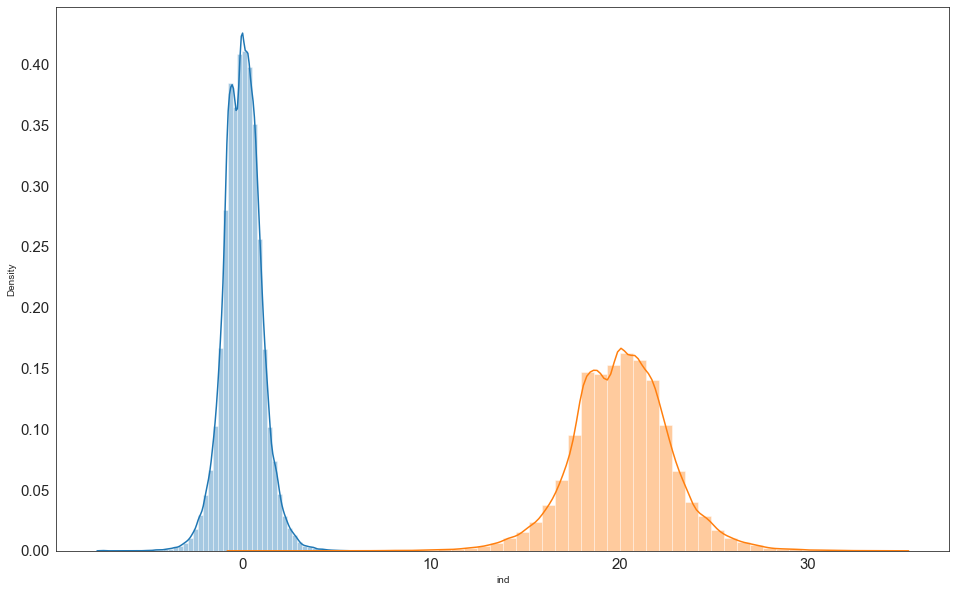

In [37]:
#sns.distplot(test_dataframe['ind'])
sns.distplot(PT_transformed)
sns.distplot(boxcox_transformed)
#sns.distplot(ss_transformed)
#sns.distplot(rs_transformed)

#plt.legend(['Power Transformer', " Box-Cox", " Standard Scaler", "Robust Scaler"])

In [ ]:
lightgbm_reg = create_model('lightgbm')
xgboost_reg = create_model('xgboost')
catboost_reg = create_model('catboost')
blender = blend_models(estimator_list=[lightgbm_reg, xgboost_reg, catboost_reg])

In [ ]:
predict_model(blender, data=X_test)

In [96]:
exp_reg = setup(fe_dataframe.modeling_dataframe.drop(["periodo"], axis=1),
                target = 'log_gasto_familiar', polynomial_features=True,
                html=False,
                verbose=False,
               silent=True)
lightgbm_reg = create_model('lightgbm')
lgbm_preds =  np.expm1(predict_model(lightgbm_reg, data=X_test)['Label'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.80050,0.99870,0.99940,0.14900,0.07200,0.06270
1,0.79410,0.97760,0.98870,0.16220,0.07110,0.06200
2,0.78940,0.98780,0.99390,0.15710,0.07160,0.06170
3,0.80540,1.01070,1.00540,0.14300,0.07270,0.06340
4,0.80150,0.99030,0.99510,0.17860,0.07160,0.06260
5,0.80210,1.00340,1.00170,0.15330,0.07210,0.06260
6,0.81210,1.02580,1.01280,0.14840,0.07280,0.06340
7,0.79960,0.98250,0.99120,0.18000,0.07170,0.06300
8,0.79010,0.98700,0.99350,0.16870,0.07160,0.06190
9,0.80330,1.01540,1.00760,0.15400,0.07260,0.06290


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

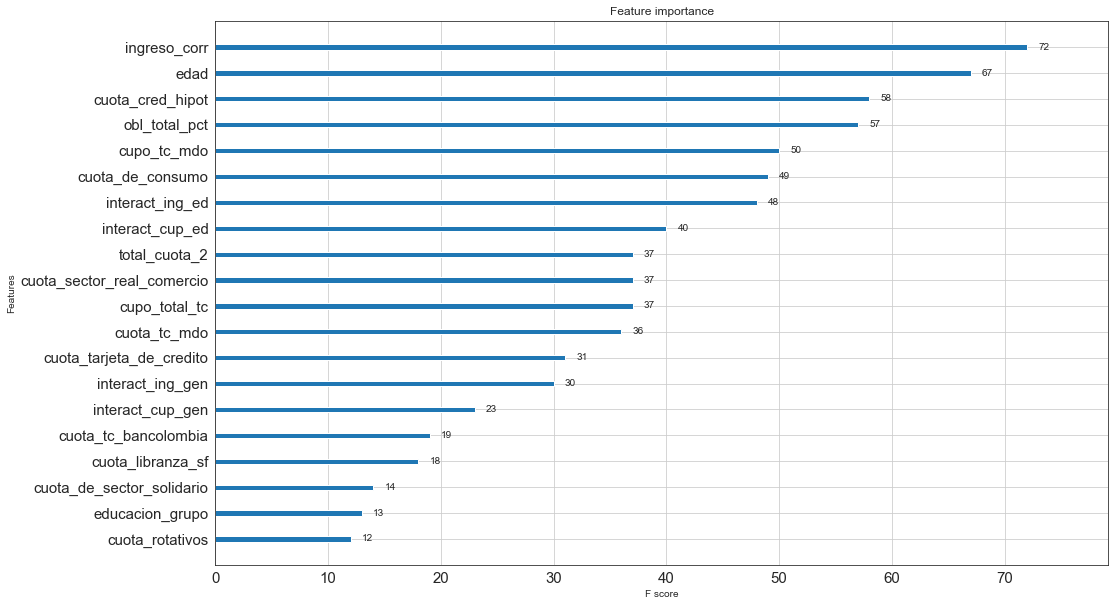

In [175]:
xgb.plot_importance(xgb_reg)

In [176]:
xgb_pred = xgb_reg.predict(X_test)
print("XGBoost: ", mean_absolute_percentage_error(xgb_pred, y_test))

elastic_pred=elastic_reg.predict(X_test)
print("Elastic Net: ", mean_absolute_percentage_error(elastic_pred, y_test))

#lasso_pred= lasso_reg.predict(X_test)
#print("Lasso: ", mean_absolute_percentage_error(lasso_pred, y_test))
      
ridge_pred=ridge_reg.predict(X_test)
print("Ridge: ", mean_absolute_percentage_error(ridge_pred, y_test))
      
catboost_pred=cat_reg.predict(X_test)
print("Catboost: ", mean_absolute_percentage_error(catboost_pred, y_test))  

ensemble_predictions = xgb_pred*0.25 + elastic_pred*0.25  +ridge_pred*0.25 +catboost_pred*0.25
print("Ensemble: ", mean_absolute_percentage_error(ensemble_predictions, y_test))

XGBoost:  0.05694882932115956
Elastic Net:  0.058023927981599534
Ridge:  0.058023291179563175
Catboost:  0.057089137290672234
Ensemble:  0.05727970121625944


In [163]:
pd.set_option('display.max_columns', 100)


In [164]:
X

,edad,categoria,cupo_total_tc,cuota_tc_bancolombia,nro_tot_cuentas,cuota_cred_hipot,mediana_nom3,mediana_pen3,cuota_de_consumo,cuota_rotativos,cuota_tarjeta_de_credito,cuota_de_sector_solidario,cuota_sector_real_comercio,cupo_tc_mdo,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,educacion_grupo,ingreso_corr,obl_total_pct,interact_ing_gen,interact_ing_ed,interact_cup_gen,interact_cup_ed,total_cuota_2,cuota_pct_cupo
0,26,2,7922.64535,2188.53329,1,0.00000,0.00000,0.00000,3902.42774,0.00000,3040.36816,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4,0,5577.24762,15.85598,0.00000,28446.69073,0.00000,40405.92007,19277490.04000,0.21251
1,29,4,0.00000,0.00000,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,5104.76062,0.00000,0.00000,27498.74552,0.00000,0.00000,0.00000,0.00000
2,41,2,3462.10219,881.03258,2,0.00000,0.00000,0.00000,2296.69615,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3167.22767,0.00000,5,1,3514.96403,11.22416,3514.96403,22517.55408,3462.10219,22179.07310,3031869.27000,0.06396
3,25,1,2754.81048,476.85335,1,0.00000,2139.48733,0.00000,1498.86041,584.51854,467.04584,0.00000,479.66794,0.00000,0.00000,0.00000,4574.02491,959.25127,4,0,3312.50871,9.11063,0.00000,16570.54066,0.00000,13782.04890,2094935.24400,0.05827
4,55,3,9998.00020,1301.84201,2,0.00000,0.00000,0.00000,1749.57187,1417.86056,3015.28421,0.00000,0.00000,23459.71358,12947.59474,545.72621,23710.61276,0.00000,12,1,8060.31505,7.55560,8060.31505,59789.72689,25501.96056,189140.43311,12495998.00000,0.01654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111810,36,1,3096.38732,525.64003,1,0.00000,2501.83731,0.00000,2240.38980,0.00000,611.19165,0.00000,0.00000,2487.98072,642.98372,646.07716,0.00000,0.00000,5,1,4070.71915,9.58991,4070.71915,24434.31204,3972.92189,23847.52838,3029352.00000,0.04100
111811,29,2,0.00000,0.00000,1,0.00000,4145.54674,0.00000,2957.19786,0.00000,1677.28675,0.00000,971.65497,8097.38294,6772.95417,918.87133,12415.72942,0.00000,5,0,5573.62086,11.31742,5573.62086,30023.63538,8097.38294,43614.51068,7198422.00000,0.04254
111812,58,1,6322.55564,914.51732,1,0.00000,0.00000,0.00000,2468.05873,764.81419,1406.54677,0.00000,0.00000,8759.50695,5401.70280,1585.45205,8977.30977,1813.49002,8,0,3974.76401,12.94560,0.00000,30284.12864,0.00000,82292.05813,7396591.06000,0.02404
111813,40,2,3222.90372,960.01537,1,0.00000,0.00000,0.00000,3166.32096,0.00000,1498.66785,0.00000,1160.75707,6478.74101,6031.90454,1275.49912,8679.70513,0.00000,4,0,4328.38428,15.99554,0.00000,27385.75208,0.00000,45780.09261,7733859.64400,0.05975


<AxesSubplot:xlabel='log_gasto_familiar', ylabel='Density'>

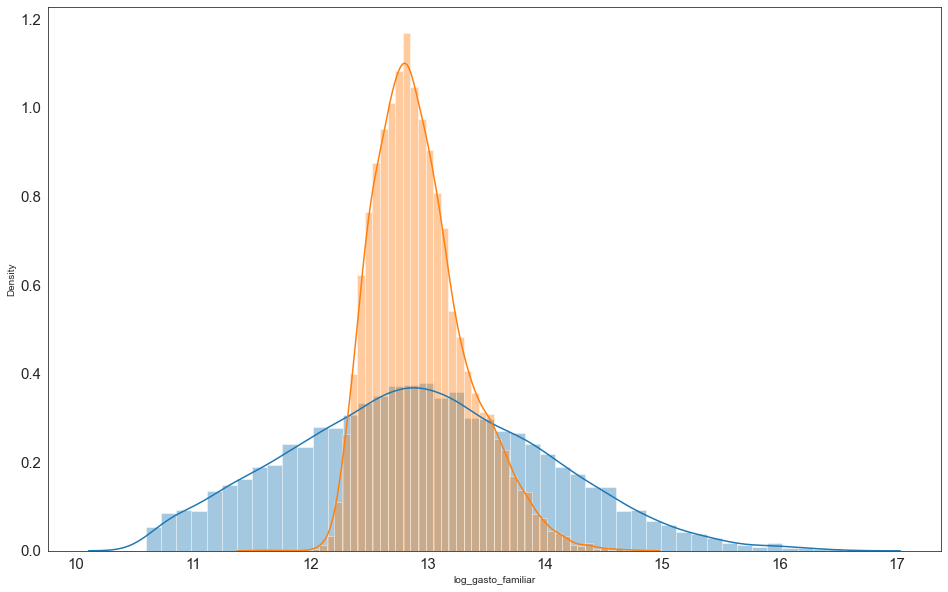

In [128]:
sns.distplot(y_test)
sns.distplot(ensemble_predictions)

In [130]:
X['total_cuota'].value_counts()

Series([], Name: total_cuota, dtype: int64)

In [501]:
X.corr().to_csv("correlations.csv")

In [ ]:
X.columns.sort_values()

# Ensemble Pipeline

In [67]:
print(f"Hora de inicio: {datetime.now()}")
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]

test_df = pd.read_csv("test_cleaned.csv")
test_df['cuota_de_consumo'] = np.where(test_df['cuota_de_consumo'] <0 ,0, test_df['cuota_de_consumo'])
test_df_modeling = DataFramePreProcessor(test_df, test=True)
test_df_modeling.process()

last_predictions_list = []
y_tests = []
y_preds = []
mapes   = []
models = []
p = 0.2

random.seed(410)

with open('tuned_hyper_parameters.json') as f:
    tuned_hyperparameters = json.load(f)

for date in dates:
    print(f"Periodo {date}:")
    raw_dataframe = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    # raw_dataframe=raw_dataframe[raw_dataframe['gasto_familiar'] >0 ] 
    print(f"     Total rows in original_data {raw_dataframe.shape[0]}" )
    fe_dataframe = DataFramePreProcessor(raw_dataframe)
    fe_dataframe.process()
    X = fe_dataframe.modeling_dataframe.drop([ "log_gasto_familiar",
                                         "periodo"], axis=1)
    y = fe_dataframe.modeling_dataframe['log_gasto_familiar']
    print(f"     Total rows in transformed_data {fe_dataframe.modeling_dataframe.shape[0]}" )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

    xgb_reg = xgb.XGBRegressor(**tuned_hyperparameters['xgb'])
    elastic_reg = ElasticNet(**tuned_hyperparameters['elasticnet'])
    ridge_reg=Ridge(**tuned_hyperparameters['ridge'])
    cat_reg = CatBoostRegressor(**tuned_hyperparameters['catboost'])  
    
    xgb_reg.fit(X_train, y_train)
    elastic_reg.fit(X_train, y_train)
    cat_reg.fit(X_train, y_train, verbose=False)
    ridge_reg.fit(X_train, y_train)
    
    models.append([xgb_reg, elastic_reg, cat_reg, ridge_reg])
    xgb_pred = xgb_reg.predict(X_test)
    elastic_pred = elastic_reg.predict(X_test)
    ridge_pred   = ridge_reg.predict(X_test)
    catboost_pred = cat_reg.predict(X_test)
    y_tests.append(y_test)
    y_preds.append([xgb_pred,elastic_pred, ridge_pred, catboost_pred])
    ensemble_prediction=xgb_pred*0.3 + elastic_pred*0.2 +ridge_pred*0.2 +catboost_pred*0.3
    mape = mean_absolute_percentage_error(ensemble_prediction, y_test)
    mapes.append(mape)
    print(f"     MAPE {date}: ", mape )
    
    month_test = test_df_modeling.modeling_dataframe[
        test_df_modeling.modeling_dataframe['periodo'] == int(date)].reset_index(drop=True)
    predictions_df = month_test.drop(["periodo","id_registro"], axis=1)
    final_prediction_xgb=np.expm1(xgb_reg.predict(predictions_df))
    final_prediction_elastic=np.expm1(elastic_reg.predict(predictions_df))
    final_prediction_ridge=np.expm1(ridge_reg.predict(predictions_df))
    final_prediction_catboost=np.expm1(cat_reg.predict(predictions_df))
    final_prediction = final_prediction_xgb*0.3 + final_prediction_elastic*0.2 + \
                        final_prediction_ridge*0.2 + final_prediction_catboost*0.3

    
    submission = pd.concat([month_test['id_registro'],pd.Series(final_prediction)], axis=1)
    submission.columns = ["id_registro", "gasto_familiar"]
    submission['gasto_familiar'] = submission['gasto_familiar'].round(4)
    #submission['gasto_familiar'] = np.where(submission['gasto_familiar'] > 10000000, 10000000, submission['gasto_familiar'])
    
    last_predictions_list.append(submission)
print(f"Hora de finalizacion: {datetime.now()}")

Hora de inicio: 2021-01-24 11:04:50.772879
Periodo 201902:
     Total rows in original_data 209265
     Total rows in transformed_data 172347
     MAPE 201902:  6.2367082839832575
Periodo 201903:
     Total rows in original_data 214880
     Total rows in transformed_data 184486
     MAPE 201903:  6.1083731325789845
Periodo 201904:
     Total rows in original_data 216039
     Total rows in transformed_data 184279
     MAPE 201904:  6.06982217452215
Periodo 201905:
     Total rows in original_data 216652
     Total rows in transformed_data 189199
     MAPE 201905:  6.0188027846501
Periodo 201907:
     Total rows in original_data 221772
     Total rows in transformed_data 198547
     MAPE 201907:  6.00694006927595
Periodo 201908:
     Total rows in original_data 222833
     Total rows in transformed_data 200426
     MAPE 201908:  5.932742796964912
Periodo 201909:
     Total rows in original_data 222838
     Total rows in transformed_data 201051
     MAPE 201909:  5.898199522156432
Periodo

# PyCaret Pipeline

In [60]:
print(f"Hora de inicio: {datetime.now()}")
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]

test_df = pd.read_csv("test_cleaned.csv")
test_df['cuota_de_consumo'] = np.where(test_df['cuota_de_consumo'] <0 ,0, test_df['cuota_de_consumo'])
test_df_modeling = DataFramePreProcessor(test_df, test=True)
test_df_modeling.process()

last_predictions_list = []
p = 0.2
random.seed(800)


for date in dates:
    print(f"Periodo {date}:")
    raw_dataframe = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    # raw_dataframe=raw_dataframe[raw_dataframe['gasto_familiar'] >0 ] 
    print(f"     Total rows in original_data {raw_dataframe.shape[0]}" )
    fe_dataframe = DataFramePreProcessor(raw_dataframe)
    fe_dataframe.process()
    print(f"     Total rows in transformed_data {fe_dataframe.modeling_dataframe.shape[0]}" )

    exp_reg = setup(fe_dataframe.modeling_dataframe.drop(["periodo"], axis=1),
                target = 'log_gasto_familiar', polynomial_features=True,
                html=False,
                verbose=False,
               silent=True)
    lightgbm_reg = create_model('lightgbm')
    #lgbm_preds =  np.expm1(predict_model(lightgbm_reg, data=X_test)['Label'])
    month_test = test_df_modeling.modeling_dataframe[
        test_df_modeling.modeling_dataframe['periodo'] == int(date)].reset_index(drop=True)
    predictions_df = month_test.drop(["periodo","id_registro"], axis=1)
    final_prediction=  np.expm1(predict_model(lightgbm_reg, data=predictions_df)['Label'])
    
    submission = pd.concat([month_test['id_registro'],pd.Series(final_prediction)], axis=1)
    submission.columns = ["id_registro", "gasto_familiar"]
    submission['gasto_familiar'] = submission['gasto_familiar'].round(4)
    #submission['gasto_familiar'] = np.where(submission['gasto_familiar'] > 10000000, 10000000, submission['gasto_familiar'])
    
    last_predictions_list.append(submission)
print(f"Hora de finalizacion: {datetime.now()}")

Hora de inicio: 2021-01-24 10:47:37.456104
Periodo 201902:
     Total rows in original_data 210022
     Total rows in transformed_data 172742
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.78730,0.97220,0.98600,0.16230,0.07110,0.06170
1,0.80050,0.99630,0.99820,0.14780,0.07190,0.06270
2,0.79740,0.99530,0.99760,0.17460,0.07180,0.06250
3,0.78330,0.96680,0.98330,0.17490,0.07070,0.06120
4,0.80330,1.00160,1.00080,0.16320,0.07210,0.06280
5,0.79950,0.99620,0.99810,0.15500,0.07180,0.06250
6,0.78880,0.97450,0.98710,0.16840,0.07110,0.06170
7,0.80240,0.99510,0.99750,0.16220,0.07190,0.06280
8,0.79080,0.98000,0.98990,0.16240,0.07130,0.06180
9,0.80060,1.00000,1.00000,0.16980,0.07200,0.06260


Periodo 201903:
     Total rows in original_data 214202
     Total rows in transformed_data 183825
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.77750,0.95680,0.97820,0.15850,0.07020,0.06050
1,0.78200,0.96570,0.98270,0.15910,0.07050,0.06080
2,0.77400,0.94560,0.97240,0.16260,0.06980,0.06030
3,0.77520,0.94720,0.97320,0.16440,0.06970,0.06020
4,0.78140,0.95470,0.97710,0.15800,0.07000,0.06070
5,0.78910,0.97180,0.98580,0.15940,0.07060,0.06130
6,0.78670,0.96590,0.98280,0.16180,0.07050,0.06120
7,0.77720,0.95160,0.97550,0.16560,0.07010,0.06060
8,0.77920,0.95460,0.97700,0.16290,0.07000,0.06060
9,0.77660,0.94330,0.97120,0.16000,0.06980,0.06050


Periodo 201904:
     Total rows in original_data 216409
     Total rows in transformed_data 184375
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.77420,0.94020,0.96960,0.17740,0.06990,0.06060
1,0.78350,0.96370,0.98170,0.16480,0.07060,0.06120
2,0.78380,0.96430,0.98200,0.16490,0.07060,0.06110
3,0.78030,0.95870,0.97910,0.16580,0.07060,0.06110
4,0.77660,0.94920,0.97430,0.16370,0.07020,0.06080
5,0.78330,0.96910,0.98440,0.16670,0.07080,0.06120
6,0.78150,0.95690,0.97820,0.16240,0.07040,0.06100
7,0.77940,0.95880,0.97920,0.17450,0.07020,0.06060
8,0.77750,0.94860,0.97400,0.17070,0.07000,0.06070
9,0.78190,0.95570,0.97760,0.16700,0.07020,0.06100


Periodo 201905:
     Total rows in original_data 217244
     Total rows in transformed_data 189758
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.77240,0.94220,0.97070,0.15040,0.06950,0.06000
1,0.76770,0.93190,0.96530,0.15820,0.06920,0.05970
2,0.76780,0.92530,0.96190,0.17090,0.06900,0.05970
3,0.77800,0.95590,0.97770,0.16290,0.07000,0.06050
4,0.78000,0.95800,0.97880,0.15440,0.07020,0.06070
5,0.77390,0.94780,0.97350,0.17210,0.06980,0.06020
6,0.77520,0.95000,0.97470,0.16530,0.06980,0.06020
7,0.77140,0.94310,0.97110,0.16290,0.06960,0.06000
8,0.76600,0.93180,0.96530,0.15810,0.06910,0.05950
9,0.77780,0.95380,0.97660,0.15290,0.07000,0.06050


Periodo 201907:
     Total rows in original_data 221111
     Total rows in transformed_data 198194
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.77440,0.96210,0.98090,0.14300,0.06990,0.05990
1,0.77460,0.96350,0.98160,0.14450,0.06990,0.05980
2,0.77890,0.96470,0.98220,0.14170,0.06990,0.06010
3,0.78460,0.97480,0.98730,0.14580,0.07020,0.06060
4,0.78390,0.97670,0.98830,0.14490,0.07020,0.06040
5,0.77100,0.95020,0.97480,0.13680,0.06950,0.05960
6,0.77180,0.94380,0.97150,0.15770,0.06920,0.05960
7,0.77750,0.97340,0.98660,0.13140,0.07020,0.06010
8,0.77780,0.96090,0.98020,0.14440,0.06980,0.06010
9,0.78210,0.97270,0.98630,0.13980,0.07010,0.06030


Periodo 201908:
     Total rows in original_data 222694
     Total rows in transformed_data 200137
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.75900,0.91280,0.95540,0.14960,0.06820,0.05870
1,0.75620,0.90670,0.95220,0.14850,0.06790,0.05850
2,0.76850,0.93260,0.96570,0.14680,0.06890,0.05950
3,0.76430,0.93000,0.96440,0.14390,0.06890,0.05930
4,0.77090,0.94360,0.97140,0.14160,0.06920,0.05950
5,0.76200,0.92020,0.95930,0.14300,0.06850,0.05910
6,0.76440,0.92230,0.96040,0.14210,0.06860,0.05920
7,0.76160,0.91850,0.95840,0.14980,0.06850,0.05910
8,0.75980,0.91260,0.95530,0.15440,0.06830,0.05890
9,0.75860,0.91170,0.95480,0.15420,0.06810,0.05870


Periodo 201909:
     Total rows in original_data 222707
     Total rows in transformed_data 200641
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.76510,0.92640,0.96250,0.14820,0.06870,0.05920
1,0.75860,0.91150,0.95470,0.15120,0.06820,0.05870
2,0.75780,0.91020,0.95410,0.15780,0.06820,0.05880
3,0.75740,0.91570,0.95690,0.14920,0.06830,0.05870
4,0.75800,0.90380,0.95070,0.15220,0.06790,0.05870
5,0.76120,0.92080,0.95960,0.15580,0.06850,0.05900
6,0.76160,0.90970,0.95380,0.15950,0.06800,0.05890
7,0.76420,0.92440,0.96150,0.15860,0.06850,0.05900
8,0.75980,0.91760,0.95790,0.15580,0.06840,0.05890
9,0.75910,0.90790,0.95280,0.15300,0.06820,0.05890


Periodo 201910:
     Total rows in original_data 224133
     Total rows in transformed_data 202871
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.75830,0.91490,0.95650,0.14600,0.06820,0.05860
1,0.75990,0.91990,0.95910,0.15580,0.06840,0.05880
2,0.75300,0.89720,0.94720,0.16540,0.06760,0.05820
3,0.76270,0.91960,0.95900,0.14840,0.06860,0.05920
4,0.76400,0.92250,0.96050,0.14320,0.06860,0.05930
5,0.75660,0.90560,0.95160,0.15490,0.06790,0.05860
6,0.75830,0.91200,0.95500,0.14880,0.06820,0.05880
7,0.76740,0.93250,0.96560,0.14260,0.06890,0.05940
8,0.76180,0.92360,0.96100,0.15680,0.06840,0.05890
9,0.75860,0.91060,0.95430,0.14410,0.06820,0.05880


Periodo 201911:
     Total rows in original_data 223858
     Total rows in transformed_data 202526
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.75650,0.90370,0.95060,0.15190,0.06780,0.05850
1,0.76520,0.92310,0.96080,0.14060,0.06860,0.05930
2,0.75580,0.91310,0.95560,0.14510,0.06810,0.05850
3,0.76590,0.93810,0.96860,0.14840,0.06910,0.05930
4,0.76280,0.92090,0.95960,0.14630,0.06860,0.05910
5,0.76190,0.92280,0.96060,0.14930,0.06840,0.05880
6,0.75460,0.90310,0.95030,0.14590,0.06780,0.05840
7,0.76080,0.92120,0.95980,0.14890,0.06840,0.05880
8,0.77190,0.93420,0.96650,0.14820,0.06890,0.05970
9,0.75940,0.90970,0.95380,0.15340,0.06800,0.05870


Periodo 202001:
     Total rows in original_data 224061
     Total rows in transformed_data 204208
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.78300,0.97530,0.98760,0.16370,0.07000,0.06010
1,0.77260,0.95210,0.97580,0.17100,0.06900,0.05920
2,0.78160,0.97440,0.98710,0.16560,0.06990,0.06000
3,0.78090,0.97190,0.98590,0.16020,0.06980,0.05990
4,0.77620,0.95660,0.97810,0.17340,0.06940,0.05970
5,0.77730,0.96500,0.98230,0.15480,0.06970,0.05980
6,0.77550,0.96920,0.98450,0.15360,0.06980,0.05960
7,0.76520,0.93980,0.96940,0.16200,0.06860,0.05870
8,0.77130,0.94670,0.97300,0.16320,0.06910,0.05930
9,0.78170,0.97480,0.98730,0.16200,0.06990,0.06000


Periodo 202002:
     Total rows in original_data 223452
     Total rows in transformed_data 203753
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.77070,0.95290,0.97620,0.15330,0.06920,0.05920
1,0.77610,0.95590,0.97770,0.14780,0.06940,0.05980
2,0.77580,0.95240,0.97590,0.15780,0.06930,0.05970
3,0.77200,0.95080,0.97510,0.14590,0.06930,0.05950
4,0.77850,0.96290,0.98130,0.15760,0.06960,0.05990
5,0.76790,0.93930,0.96920,0.16640,0.06880,0.05910
6,0.76600,0.92990,0.96430,0.15850,0.06840,0.05890
7,0.76690,0.93280,0.96580,0.16180,0.06850,0.05890
8,0.76790,0.93320,0.96600,0.16170,0.06860,0.05910
9,0.76810,0.93640,0.96770,0.15560,0.06880,0.05920


Periodo 202003:
     Total rows in original_data 224724
     Total rows in transformed_data 206412
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.75770,0.91570,0.95690,0.15220,0.06780,0.05810
1,0.76360,0.93290,0.96580,0.14650,0.06840,0.05860
2,0.75110,0.90070,0.94910,0.15880,0.06720,0.05750
3,0.75110,0.90460,0.95110,0.14440,0.06740,0.05770
4,0.76460,0.93400,0.96640,0.14900,0.06840,0.05860
5,0.74830,0.89660,0.94690,0.14500,0.06720,0.05750
6,0.75630,0.90860,0.95320,0.14990,0.06760,0.05810
7,0.75350,0.90690,0.95230,0.14630,0.06750,0.05790
8,0.75470,0.90710,0.95240,0.14220,0.06740,0.05790
9,0.74640,0.89310,0.94510,0.15850,0.06710,0.05730


Periodo 202004:
     Total rows in original_data 222160
     Total rows in transformed_data 189591
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.75110,0.88570,0.94110,0.07640,0.06760,0.05850
1,0.76140,0.91240,0.95520,0.08410,0.06860,0.05930
2,0.75850,0.90310,0.95030,0.08000,0.06820,0.05900
3,0.75590,0.89770,0.94750,0.08800,0.06810,0.05890
4,0.75660,0.89750,0.94730,0.07770,0.06800,0.05890
5,0.75650,0.89920,0.94820,0.07130,0.06820,0.05890
6,0.75630,0.90110,0.94920,0.08140,0.06810,0.05880
7,0.75850,0.90340,0.95050,0.08190,0.06830,0.05910
8,0.75380,0.89230,0.94460,0.08380,0.06780,0.05860
9,0.76090,0.90560,0.95160,0.07840,0.06840,0.05920


Periodo 202005:
     Total rows in original_data 222293
     Total rows in transformed_data 196465
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.76580,0.92560,0.96210,0.08750,0.06860,0.05910
1,0.76510,0.92330,0.96090,0.08030,0.06840,0.05900
2,0.76920,0.93190,0.96540,0.08260,0.06890,0.05940
3,0.76010,0.91840,0.95830,0.08590,0.06830,0.05870
4,0.76740,0.93570,0.96730,0.07580,0.06900,0.05920
5,0.76340,0.92390,0.96120,0.08620,0.06860,0.05900
6,0.76430,0.93010,0.96440,0.07900,0.06870,0.05900
7,0.76140,0.91970,0.95900,0.08650,0.06830,0.05860
8,0.76140,0.92300,0.96070,0.08930,0.06840,0.05880
9,0.76600,0.92820,0.96340,0.07410,0.06860,0.05900


Periodo 202007:
     Total rows in original_data 223100
     Total rows in transformed_data 200204
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.79690,1.01700,1.00850,0.09860,0.07120,0.06090
1,0.78880,1.00060,1.00030,0.08460,0.07050,0.06020
2,0.79020,1.00680,1.00340,0.09680,0.07080,0.06030
3,0.78780,0.99870,0.99940,0.09380,0.07050,0.06020
4,0.79640,1.01430,1.00710,0.09300,0.07130,0.06110
5,0.79530,1.01750,1.00870,0.09700,0.07120,0.06080
6,0.81150,1.05170,1.02550,0.09190,0.07250,0.06210
7,0.79310,1.00670,1.00330,0.10590,0.07080,0.06070
8,0.79870,1.01980,1.00980,0.09650,0.07140,0.06120
9,0.79240,1.00880,1.00440,0.09980,0.07090,0.06060


Periodo 202008:
     Total rows in original_data 223551
     Total rows in transformed_data 200855
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.78820,0.98960,0.99480,0.10110,0.07060,0.06050
1,0.78810,0.99660,0.99830,0.10020,0.07080,0.06060
2,0.78570,0.98400,0.99200,0.10380,0.07030,0.06030
3,0.77970,0.97120,0.98550,0.10250,0.06990,0.05990
4,0.78900,0.99230,0.99610,0.09990,0.07080,0.06080
5,0.78380,0.98390,0.99190,0.09540,0.07020,0.06010
6,0.78940,0.98590,0.99290,0.10110,0.07030,0.06050
7,0.78720,0.99200,0.99600,0.09620,0.07050,0.06040
8,0.78300,0.97550,0.98770,0.10200,0.07000,0.06010
9,0.78640,0.98680,0.99340,0.10810,0.07040,0.06040


Periodo 202009:
     Total rows in original_data 221973
     Total rows in transformed_data 200241
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.76750,0.94370,0.97150,0.12520,0.06870,0.05880
1,0.76850,0.94470,0.97200,0.11920,0.06890,0.05900
2,0.76850,0.94380,0.97150,0.12140,0.06880,0.05890
3,0.76940,0.95020,0.97480,0.12140,0.06900,0.05890
4,0.76920,0.95610,0.97780,0.11660,0.06910,0.05890
5,0.77420,0.95530,0.97740,0.12010,0.06910,0.05920
6,0.77540,0.96950,0.98460,0.11130,0.06960,0.05940
7,0.77020,0.95040,0.97490,0.11400,0.06910,0.05910
8,0.76790,0.94340,0.97130,0.11770,0.06870,0.05880
9,0.77240,0.95630,0.97790,0.11730,0.06920,0.05930


Periodo 202010:
     Total rows in original_data 221712
     Total rows in transformed_data 200470
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.76990,0.95410,0.97680,0.09750,0.06900,0.05890
1,0.76510,0.94650,0.97290,0.11120,0.06870,0.05850
2,0.76580,0.94090,0.97000,0.10060,0.06860,0.05860
3,0.76500,0.93910,0.96910,0.10360,0.06840,0.05840
4,0.77280,0.96180,0.98070,0.10450,0.06930,0.05920
5,0.76820,0.94650,0.97290,0.10390,0.06880,0.05880
6,0.76660,0.94560,0.97240,0.09940,0.06870,0.05860
7,0.76800,0.94710,0.97320,0.10080,0.06880,0.05880
8,0.77380,0.96310,0.98140,0.09840,0.06930,0.05910
9,0.77010,0.95280,0.97610,0.10610,0.06890,0.05890


Periodo 202011:
     Total rows in original_data 220223
     Total rows in transformed_data 197838
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.78240,0.98350,0.99170,0.10300,0.07020,0.05990
1,0.77940,0.98220,0.99110,0.09920,0.07000,0.05960
2,0.77660,0.97330,0.98660,0.10140,0.06980,0.05950
3,0.78060,0.97540,0.98760,0.10710,0.06960,0.05950
4,0.79050,0.99830,0.99910,0.09740,0.07060,0.06040
5,0.78200,0.99050,0.99530,0.10800,0.07020,0.05970
6,0.77830,0.96580,0.98270,0.10010,0.06940,0.05950
7,0.77860,0.97680,0.98830,0.10930,0.06980,0.05950
8,0.78280,0.98530,0.99260,0.09740,0.07000,0.05970
9,0.77710,0.97620,0.98800,0.10350,0.06960,0.05930


Hora de finalizacion: 2021-01-24 10:59:45.906092


In [68]:
ensemble_df= pd.concat(last_predictions_list, axis=0)
ensemble_df

,id_registro,gasto_familiar
0,4055#201902,434466.16800
1,12598#201902,525396.03890
2,23697#201902,432622.80740
3,23768#201902,437185.80130
4,7174#201902,490967.06230
...,...,...
14819,8596193#202011,575851.77000
14820,8616083#202011,604260.70580
14821,8670207#202011,1069524.05360
14822,8677655#202011,491073.76830


In [34]:
predictions_df = test_df_modeling.modeling_dataframe.drop(["periodo","id_registro"], axis=1)
predictions_list = []
for model in models:
    final_predictions_xgb=np.expm1(model[0].predict(predictions_df))
    final_predictions_elastic=np.expm1(model[1].predict(predictions_df))
    final_predictions_ridge=np.expm1(model[2].predict(predictions_df))
    final_predictions_catboost=np.expm1(model[3].predict(predictions_df))

    final_prediction=final_predictions_xgb*0.5+final_predictions_elastic*0.0 + \
                       final_predictions_ridge*0.0 + final_predictions_catboost*0.5
    
    predictions_list.append(final_prediction)

In [37]:
stack =  predictions_list[0] +\
predictions_list[1] + \
predictions_list[2] + \
predictions_list[3] + \
predictions_list[4] + \
predictions_list[5] + \
predictions_list[6] + \
predictions_list[7] + \
predictions_list[8] + \
predictions_list[9] + \
predictions_list[10] + \
predictions_list[11] + \
predictions_list[12] + \
predictions_list[13] + \
predictions_list[14] + \
predictions_list[15] + \
predictions_list[16] + \
predictions_list[17] + \
predictions_list[18] 

final_prediction=stack / 19

In [38]:
submission = pd.concat([test_df['id_registro'],pd.Series(final_prediction)], axis=1)
submission.columns = ["id_registro", "gasto_familiar"]
submission['gasto_familiar'] = submission['gasto_familiar'].round(4)
#submission['gasto_familiar'] = np.where(submission['gasto_familiar'] > 10000000, 10000000, submission['gasto_familiar'])
submission

,id_registro,gasto_familiar
0,4055#201902,694324.77260
1,12598#201902,512304.01210
2,23697#201902,648476.75590
3,23768#201902,504399.35740
4,7174#201902,890295.15490
...,...,...
281661,8596193#202011,559719.83720
281662,8616083#202011,1348203.51510
281663,8670207#202011,1334471.07060
281664,8677655#202011,954877.53440


In [39]:
# submission.to_csv("submission_underground.csv", index=False)

In [61]:
by_month= pd.concat(last_predictions_list, axis=0)
by_month

,id_registro,gasto_familiar
0,4055#201902,475272.71250
1,12598#201902,412795.53500
2,23697#201902,484375.62220
3,23768#201902,429720.96080
4,7174#201902,477976.86730
...,...,...
14819,8596193#202011,507311.49070
14820,8616083#202011,657402.66590
14821,8670207#202011,698470.27600
14822,8677655#202011,366197.16340


In [69]:
(by_month['gasto_familiar'] + ensemble_df['gasto_familiar']) / 2

0       454869.44025
1       469095.78695
2       458499.21480
3       433453.38105
4       484471.96480
            ...     
14819   541581.63035
14820   630831.68585
14821   883997.16480
14822   428635.46585
14823   613230.68400
Name: gasto_familiar, Length: 281666, dtype: float64

In [76]:
final_prediction_df = pd.concat(
    [by_month['id_registro'],
    (by_month['gasto_familiar'] + ensemble_df['gasto_familiar']) / 2],
    axis=1
)
final_prediction_df

,id_registro,gasto_familiar
0,4055#201902,454869.44025
1,12598#201902,469095.78695
2,23697#201902,458499.21480
3,23768#201902,433453.38105
4,7174#201902,484471.96480
...,...,...
14819,8596193#202011,541581.63035
14820,8616083#202011,630831.68585
14821,8670207#202011,883997.16480
14822,8677655#202011,428635.46585


In [80]:
final_prediction_df.to_csv("submission_underground.csv", index=False)

In [62]:
by_month.to_csv("submission_underground.csv", index=False)

In [63]:
by_month['gasto_familiar'].value_counts()

503661.57100    183
455437.29340    179
507969.07460    160
589190.34980    154
614867.60730    150
               ... 
414078.50200      1
559862.03830      1
405331.16460      1
428437.12460      1
470302.55720      1
Name: gasto_familiar, Length: 237077, dtype: int64

In [467]:
np.mean(mapes)

0.058276630192139335

# GLM

In [106]:
# Fit Poisson regression of sat by weight\
glm_feat_formula = [
    'ingreso_corr_log',
    'cuota_cred_hipot_log',
    'cupo_total_tc_log',
    # 'cuota_tarjeta_de_credito_log',
    'cuota_de_consumo_log',
    'edad',
    # 'genero',
    'cuota_tc_bancolombia_log',
    'ind_annio',
    # 'cupo_tc_mdo_log',
   # 'edad:ingreso_corr',
   # 'edad*cuota_cred_hipot_log',
   #  'genero:ingreso_corr',
    'obl_total_pct',
    'ingreso_geo_alto',
    'ingreso_cero',
    'es_ciudad_principal'
]
glm_formula = 'np.log(gasto_familiar+1) ~ ' + ' + '.join(feature_cols)
glm_features = feature_cols + ['gasto_familiar']
glm_data = fe_dataframe.modeling_dataframe[glm_features]
# glm_data = glm_data[glm_data['gasto_familiar'] < 10000000]
model = glm( glm_formula, data = glm_data,
            family = sm.families.Poisson()).fit()

# Display model results
print(model.summary())

                     Generalized Linear Model Regression Results                      
Dep. Variable:     np.log(gasto_familiar + 1)   No. Observations:                78875
Model:                                    GLM   Df Residuals:                    78858
Model Family:                         Poisson   Df Model:                           16
Link Function:                            log   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:            -2.0000e+05
Date:                        Wed, 20 Jan 2021   Deviance:                       56226.
Time:                                17:37:25   Pearson chi2:                 3.06e+04
No. Iterations:                             4                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

# DL model

In [150]:
nn_model = Sequential()
nn_model.add(Dense(30, activation = 'relu', input_shape = (X.shape[1],))) #Primera capa oculta, justo después de la capa input de 3 variables
nn_model.add(Dropout(0.2))
nn_model.add(Dense(30, activation = 'relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dense(30, activation = 'relu'))
nn_model.add(Dense(1))

nn_model.compile(optimizer = 'adam', loss = 'mse')
nn_model.fit(X_train, y_train, epochs=20)

Epoch 1/20
3355/3355 [==============================] - 5s 1ms/step - loss: 38.2824
Epoch 2/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.7941
Epoch 3/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.4961
Epoch 4/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.8006
Epoch 5/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.6510
Epoch 6/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.3454
Epoch 7/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.5507
Epoch 8/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.4897
Epoch 9/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.5531
Epoch 10/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.5549
Epoch 11/20
3355/3355 [==============================] - 4s 1ms/step - loss: 12.3447
Epoch 12/20
3355/3355 [==============================] - 4s 1ms/step - los

In [87]:
nn_predictions = nn_model.predict(X_test)
mean_absolute_percentage_error(nn_predictions, y_test)

0.8384442947941376

# test

In [92]:
class PrepareSubmission:
    
    def __init__(self, dataframe, model):
        self.test_dataframe = dataframe
        self.model = model
     
    def makePrediction(self, dataframe)
        test_df_modeling = DataFramePreProcessor(test_df, test=True)
        test_df_modeling.process()
        final_predictions=xgb_reg.predict(test_df_modeling.modeling_dataframe[feature_cols])
    
    
    def prepareSubmissionDF(self, dataframe):
        submission = pd.concat([test_df['id_registro'],pd.Series(final_predictions)], axis=1)
        submission.columns = ["id_registro", "gasto_familiar"]
    
    
    def submit(self):
        submission.to_csv("submission_underground.csv", index=False)

# Compare predictions


In [64]:
best_submission = pd.read_csv("submission_underground XGB,CAT,LASSO,RIDGE,ELASTIC.csv")
best_submission_2 =  pd.read_csv("submission_underground XGBoost+17meses+Boxcox+Log.csv")

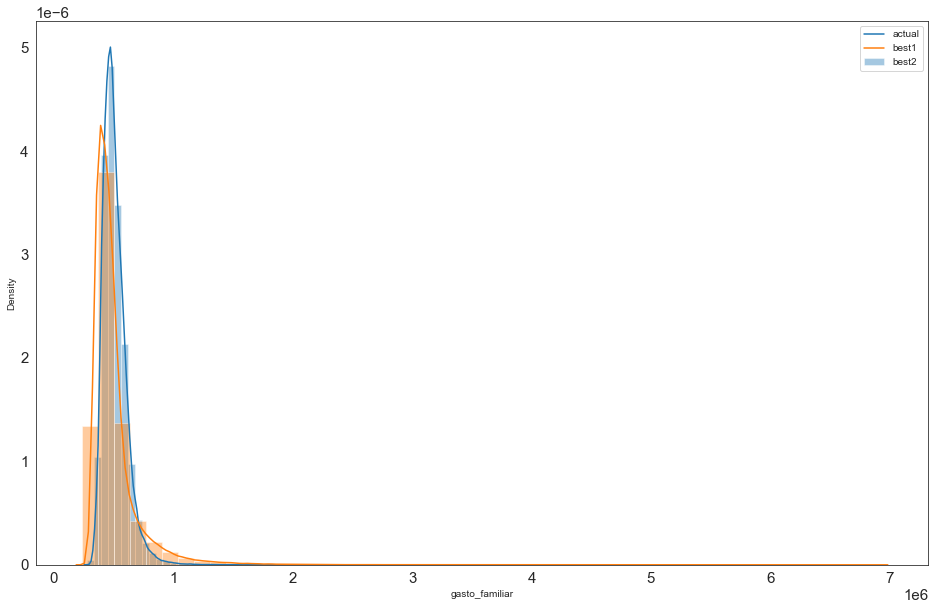

In [79]:
#sns.distplot(submission['gasto_familiar'])
#sns.distplot(fe_dataframe.modeling_dataframe['gasto_familiar'])
#sns.distplot(by_month[by_month['gasto_familiar'] < 10000000]['gasto_familiar'])
sns.distplot(final_prediction_df[final_prediction_df['gasto_familiar'] < 10000000]['gasto_familiar'])

#sns.distplot(best_submission_2[best_submission_2['gasto_familiar'] < 10000000]['gasto_familiar'])
sns.distplot(best_submission[best_submission['gasto_familiar'] < 10000000]['gasto_familiar'])

plt.legend(['actual','best1', 'best2'])

In [334]:
best_submission['gasto_familiar'].describe()

count     281666.00000
mean      501804.50073
std       211217.20308
min       238665.81880
25%       388865.94178
50%       449492.94245
75%       532997.98152
max     11663100.22080
Name: gasto_familiar, dtype: float64

In [49]:
by_month['gasto_familiar'].describe()

count     281666.00000
mean      642396.13074
std       318154.30947
min       198481.53610
25%       440737.73995
50%       565184.92865
75%       747725.18257
max     32329395.58200
Name: gasto_familiar, dtype: float64

In [ ]:
def submit_predictions(name,model):
    df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'), 
                                   index_col='match_id_hash')
    X_test = df_test_features.values
    y_test_pred = model.predict_proba(X_test)[:, 1]

    df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred}, 
                                 index=df_test_features.index)
    submission_filename = 'submission_{}.csv'.format(name)
    df_submission.to_csv(submission_filename)
    print('Submission saved to {}'.format(submission_filename))
    
submit_predictions('simple_cat_boost',model=base_model)


In [270]:
np.log(104107969.83870)

18.46093909010424